In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.polynomial import Polynomial

# Set the float format to prevent scientific notation
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)

ma = pd.read_csv('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/ma2020/ma_ntl_data.csv')

ma = ma[ma['avg_ntl'] != '#DIV/0!']
ma['avg_ntl'] = ma['avg_ntl'].astype(float)
ma['total_population'] = pd.to_numeric(ma['total_population'], errors='coerce')
ma = ma.dropna(subset=['total_population'])
ma['total_population'] = ma['total_population'].astype(float)
values_to_drop = ['west pgs', 'New District', 'New Districtffff', 'Sadaruru']
# Dropping rows with specified values in the 'District' column
ma = ma[~ma['District'].isin(values_to_drop)]

meg = ma.copy()
meg["ntl_pc"]= meg['avg_ntl']/meg['total_population']
meg['ntl_adm']= 0.0 
meg["ntl_edu"]= 0.0 
meg["ntl_med"]= 0.0 
meg["ntl_adm"]= meg['avg_ntl'] * 0.0522
meg["ntl_edu"]= meg['avg_ntl'] * 0.0395
meg["ntl_med"]= meg['avg_ntl'] * 0.0098

meg["ntl_pc"]= meg['avg_ntl']/meg['total_population']
meg["ntl_pc_adm"]= meg['ntl_adm']/meg['total_population']
meg["ntl_pc_edu"]= meg['ntl_edu']/meg['total_population']
meg["ntl_pc_med"]= meg['ntl_med']/meg['total_population']


/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_72876/1654013351.py:13: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  ma = pd.read_csv('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/ma2020/ma_ntl_data.csv')


### District

In [2]:
meg_dist = meg.groupby(['District','District_code','State']).agg({'avg_ntl': 'sum', 'total_population': 'sum'}).reset_index()
meg_dist['avg_ntl'] = meg_dist['avg_ntl'].astype(float)
meg_dist = meg_dist.rename(columns={'avg_ntl': 'dist_ntl', 'total_population': 'dist_population'})
meg_dist['dist_ntl_pc'] = meg_dist['dist_ntl']/meg_dist['dist_population']

total_population_sum = meg_dist['dist_population'].sum()
print(f"Total State Population Sum: {total_population_sum}")

Total State Population Sum: 951788450.0


In [29]:
meg_all_dist = pd.merge(meg, meg_dist, on=['District','District_code','State'], how='outer')
# mer_all_dist = pd.merge(mer_all_dist, mer_dist_adm, on=['District','District_code','State'], how='outer')
# mer_all_dist = pd.merge(mer_all_dist, mer_dist_edu, on=['District','District_code','State'], how='outer')
# mer_all_dist = pd.merge(mer_all_dist, mer_dist_med, on=['District','District_code','State'], how='outer')
meg_all_dist['pop_share'] = meg_all_dist['total_population']/meg_all_dist['dist_population']
# meg_all_dist
meg_sorted = meg_all_dist.sort_values(by=['District', 'ntl_pc'])
meg_sorted['Index'] = meg_sorted.groupby('District').cumcount() + 1
# Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
meg_sorted['Max_Len'] = meg_sorted.groupby('District')['Index'].transform('max')
# meg_sorted

In [4]:

def calculate_alesina(group):
    sum_y = group['ntl_pc'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

def calculate_alesina_adm(group):
    sum_y = group['ntl_pc_adm'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc_adm'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

def calculate_alesina_edu(group):
    sum_y = group['ntl_pc'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc_edu'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

def calculate_alesina_med(group):
    sum_y = group['ntl_pc'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc_med'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])


# Calculate WCV for each state using groupby and apply
all = meg_sorted.groupby(['District','District_code','State','dist_ntl','dist_population','dist_ntl_pc']).apply(calculate_alesina).reset_index()
all_adm = meg_sorted.groupby(['District','District_code','State']).apply(calculate_alesina_adm).reset_index()
all_edu = meg_sorted.groupby(['District','District_code','State']).apply(calculate_alesina_edu).reset_index()
all_med = meg_sorted.groupby(['District','District_code','State']).apply(calculate_alesina_med).reset_index()

# Reset the index and rename the result column
all.columns = ['District','District_code','State','dist_ntl',
               'dist_population','dist_ntl_pc','sum_y','numerator', 'num','alesina']
all_adm.columns = ['District','District_code','State',
               'sum_y_adm','numerator_adm', 'num_adm','alesina_adm']
all_edu.columns = ['District','District_code','State',
               'sum_y_edu','numerator_edu', 'num_edu','alesina_edu']
all_med.columns = ['District','District_code','State',
               'sum_y_med','numerator_med', 'num_med','alesina_med']

all

,District,District_code,State,dist_ntl,dist_population,dist_ntl_pc,sum_y,numerator,num,alesina
0,24 PARAGANAS NORTH,337.00000,WESTBENGAL,27768.72298,5979790.00000,0.00464,68.41514,3478.54972,1563.00000,0.93558
1,24 PARAGANAS SOUTH,343.00000,WESTBENGAL,35600.34826,8740691.00000,0.00407,39.60789,6188.25534,2031.00000,0.84664
2,ADILABAD,532.00000,TELANGANA,14509.40529,557344.00000,0.02603,71.87995,3159.57109,509.00000,0.82925
3,AGAR MALWA,0.00000,MADHYA PRADESH,7963.81906,504286.00000,0.01579,8.18986,1238.25226,437.00000,0.31033
4,AGRA a,146.00000,UTTAR PRADESH,24309.54446,2669545.00000,0.00911,70.18014,1825.49076,720.00000,0.92913
...,...,...,...,...,...,...,...,...,...,...
587,YAVATMAL,510.00000,MAHARASHTRA,39435.12096,2166418.00000,0.01820,1501.15943,62798.81702,1888.00000,0.95621
588,demoz,0.00000,ANDHRA PRADESH,478.78793,60945.00000,0.00786,1.83225,67.93247,139.00000,0.47373
589,rewa a,0.00000,UTTAR PRADESH,24145.74876,3116857.00000,0.00775,14.69595,4914.19646,1282.00000,0.47911
590,test dist,0.00000,ANDHRA PRADESH,59767.31391,2217985.00000,0.02695,145.61037,14037.98942,1200.00000,0.84015


In [22]:
gini = pd.merge(all, all_adm, on=['District','District_code','State'], how='left')
gini = pd.merge(gini, all_edu, on=['District','District_code','State'], how='left')
gini = pd.merge(gini, all_med, on=['District','District_code','State'], how='left')
gini

,District,District_code,State,dist_ntl,dist_population,dist_ntl_pc,sum_y,numerator,num,alesina,sum_y_adm,numerator_adm,num_adm,alesina_adm,sum_y_edu,numerator_edu,num_edu,alesina_edu,sum_y_med,numerator_med,num_med,alesina_med
0,24 PARAGANAS NORTH,337.00000,WESTBENGAL,27768.72298,5979790.00000,0.00464,68.41514,3478.54972,1563.00000,0.93558,3.57127,181.58030,1563.00000,0.93558,68.41514,137.40271,1563.00000,0.99807,68.41514,34.08979,1563.00000,1.00000
1,24 PARAGANAS SOUTH,343.00000,WESTBENGAL,35600.34826,8740691.00000,0.00407,39.60789,6188.25534,2031.00000,0.84664,2.06753,323.02693,2031.00000,0.84664,39.60789,244.43609,2031.00000,0.99442,39.60789,60.64490,2031.00000,0.99898
2,ADILABAD,532.00000,TELANGANA,14509.40529,557344.00000,0.02603,71.87995,3159.57109,509.00000,0.82925,3.75213,164.92961,509.00000,0.82925,71.87995,124.80306,509.00000,0.99514,71.87995,30.96380,509.00000,1.00027
3,AGAR MALWA,0.00000,MADHYA PRADESH,7963.81906,504286.00000,0.01579,8.18986,1238.25226,437.00000,0.31033,0.42751,64.63677,437.00000,0.31033,8.18986,48.91096,437.00000,0.97496,8.18986,12.13487,437.00000,0.99551
4,AGRA a,146.00000,UTTAR PRADESH,24309.54446,2669545.00000,0.00911,70.18014,1825.49076,720.00000,0.92913,3.66340,95.29062,720.00000,0.92913,70.18014,72.10688,720.00000,0.99853,70.18014,17.88981,720.00000,1.00068
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
587,YAVATMAL,510.00000,MAHARASHTRA,39435.12096,2166418.00000,0.01820,1501.15943,62798.81702,1888.00000,0.95621,78.36052,3278.09825,1888.00000,0.95621,1501.15943,2480.55327,1888.00000,0.99878,1501.15943,615.42841,1888.00000,1.00010
588,demoz,0.00000,ANDHRA PRADESH,478.78793,60945.00000,0.00786,1.83225,67.93247,139.00000,0.47373,0.09564,3.54607,139.00000,0.47373,1.83225,2.68333,139.00000,0.98612,1.83225,0.66574,139.00000,1.00197
589,rewa a,0.00000,UTTAR PRADESH,24145.74876,3116857.00000,0.00775,14.69595,4914.19646,1282.00000,0.47911,0.76713,256.52106,1282.00000,0.47911,14.69595,194.11076,1282.00000,0.98017,14.69595,48.15913,1282.00000,0.99567
590,test dist,0.00000,ANDHRA PRADESH,59767.31391,2217985.00000,0.02695,145.61037,14037.98942,1200.00000,0.84015,7.60086,732.78305,1200.00000,0.84015,145.61037,554.50058,1200.00000,0.99449,145.61037,137.57230,1200.00000,0.99926


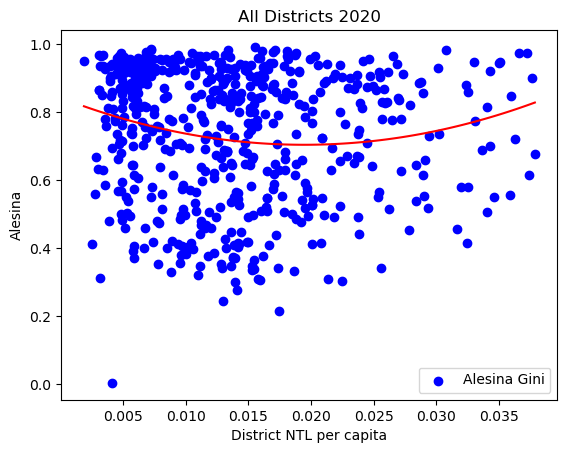

In [23]:
gini = gini[gini['dist_ntl_pc'] <= 0.04]
# gini = gini[gini['alesina'] > 0]
# gini = gini[gini['alesina'] < 1]

# Create a scatterplot
plt.scatter(gini['dist_ntl_pc'], gini['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Alesina")
plt.title("All Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(gini['dist_ntl_pc'], gini['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(gini['dist_ntl_pc']), max(gini['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')

# plt.ylim(0, 1)

# Add a legend
plt.legend()
# Display the plot
plt.show()

In [7]:
# # Get unique state names
# unique_states = gini['State'].unique()

# # Create separate scatter plots with best fit line for each state
# for state in unique_states:
#     pb = gini[gini['State'] == state]


#     plt.scatter(pb['dist_ntl_pc'], pb['alesina'], label='Alesina Gini', color='blue', marker='o')
#     # Add labels and title
#     plt.xlabel("District NTL per capita")
#     plt.ylabel("Alesina")
#     plt.title("All Districts")
#     # Fit a polynomial best fit line (e.g., a quadratic curve)
#     coefficients = np.polyfit(pb['dist_ntl_pc'], pb['alesina'], 2)  # Adjust the degree as needed
#     polynomial = np.poly1d(coefficients)
#     x_range = np.linspace(min(pb['dist_ntl_pc']), max(pb['dist_ntl_pc']), 100)
#     y_fit = polynomial(x_range)
#     # Plot the polynomial best fit line
#     plt.plot(x_range, y_fit, color='red')

#     # Set x and y-axis limits
#     plt.xlim(0, 0.04)
#     plt.ylim(0, 1)

#     # Add labels, title, legend, and show plot
#     plt.xlabel("District NTL per capita")
#     plt.ylabel("WCV")
#     plt.title(f"Scatter Plot with Best Fit Line for {state}")
#     # plt.legend()
#     plt.show()


### Sub-District

In [8]:
# sub = ma.copy()
# sub["ntl_pc"]= sub['avg_ntl']/sub['total_population']
mer_sub = meg.groupby(['Subdistrict','District','District_code','State']).agg({'avg_ntl': 'sum', 'total_population': 'sum'}).reset_index()
mer_sub['avg_ntl'] = mer_sub['avg_ntl'].astype(float)
mer_sub = mer_sub.rename(columns={'avg_ntl': 'subdist_ntl', 'total_population': 'subdist_population'})
mer_sub['dist_ntl_pc'] = mer_sub['subdist_ntl']/mer_sub['subdist_population']
mer_all_sub = pd.merge(meg, mer_sub, on=['Subdistrict','District','District_code','State'], how='outer')
# mer_all_sub

In [9]:
sub_sorted = mer_all_sub.sort_values(by=['District', 'Subdistrict','ntl_pc'])
sub_sorted['Index'] = sub_sorted.groupby('Subdistrict').cumcount() + 1
# Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
sub_sorted['Max_Len'] = sub_sorted.groupby('Subdistrict')['Index'].transform('max')
sub_sorted

,202001,202002,202003,202004,202005,202006,202007,202008,202009,202010,202011,202012,avg_ntl,med_ntl,DTNAME,State_code,State,State_census_code,District_census_code,District,District_code,SubDistric,Subdistrict,Subdistr_2,village_code,Village,Block_code,Block,state_code,state_name,district_code,district_name,sub_district_code,sub_district_name,block_code,block_name,gp_code,gp_name,village_name,village_pin_code,pc_code,ac_code,other_assembly_constituencies,total_population,male_population,female_population,total_hhd,total_hhd_engaged_in_farm_activities,total_hhd_engaged_in_non_farm_activities,total_cultivable_area_in_hac,total_hhd_having_bpl_cards,is_primary_school_with_electricity,primary_school_toilet,is_primary_school_with_computer_lab,is_primary_school_with_playground,is_primary_school_have_drinking_water,availability_of_mid_day_meal_scheme,total_primary_school_students,total_primary_school_teachers,no_of_children_not_attending_school,is_aanganwadi_centre_available,is_early_childhood_edu_provided_in_anganwadi,total_childs_aged_0_to_3_years,total_childs_aged_0_to_3_years_reg_under_aanganwadi,total_childs_aged_3_to_6_years_reg_under_aanganwadi,total_childs_aged_0_to_3_years_immunized,total_childs_categorized_non_stunted_as_per_icds,total_anemic_pregnant_women,total_anemic_adolescent_girls,total_underweight_child_age_under_6_years,total_male_child_age_bw_0_6,total_female_child_age_bw_0_6,total_hhd_with_more_than_2_childs,total_no_of_registered_children_in_anganwadi,total_no_of_children_0_to_6_years_immunized_under_icds,nearest_urban_centre,nearest_urban_proximity,area_sq_km,agro,edu,med,electric,road,transportadmin,ntl_pc,ntl_adm,ntl_edu,ntl_med,ntl_pc_adm,ntl_pc_edu,ntl_pc_med,subdist_ntl,subdist_population,dist_ntl_pc,Index,Max_Len
498009,4.44351,4.90339,4.99293,5.41471,4.78350,3.60352,2.24898,2.60787,0.00000,4.04546,5.34326,4.02563,4.21934,4.44351,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2322.00000,Amdanga,2322.00000,322989.00000,Harapur,2723.00000,AMDANGA,19.00000,WEST BENGAL,303.00000,24 PARAGANAS NORTH,2322.00000,Amdanga,2723.00000,AMDANGA,107782.00000,MARICHA,Harapur,743711.00000,227.00000,1917.00000,NaN,2285.00000,1163.00000,1122.00000,437.00000,81.00000,45.00000,52.00000,127.00000,1,0,0,1,1,1,61.00000,3.00000,0.00000,1,1,62.00000,22.00000,37.00000,22.00000,0.00000,3.00000,0.00000,0.00000,34.00000,28.00000,42.00000,37.00000,22.00000,Haringhata,5.66798,1.25462,0,1,2,1,2,0,0.00185,0.22025,0.16666,0.04135,0.00010,0.00007,0.00002,1133.67593,220019.00000,0.00515,1,78
498008,4.33229,4.97927,5.39940,6.39711,4.90331,4.71239,3.16922,3.17748,0.00000,4.13878,5.68771,4.56632,4.67848,4.71239,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2322.00000,Amdanga,2322.00000,323028.00000,Gajbanda,2723.00000,AMDANGA,19.00000,WEST BENGAL,303.00000,24 PARAGANAS NORTH,2322.00000,Amdanga,2723.00000,AMDANGA,107783.00000,SADHANPUR,Gajbanda,743221.00000,227.00000,1917.00000,NaN,2388.00000,1204.00000,1184.00000,482.00000,360.00000,122.00000,143.00000,120.00000,1,0,0,0,0,1,160.00000,4.00000,0.00000,1,1,125.00000,125.00000,45.00000,125.00000,125.00000,0.00000,0.00000,0.00000,90.00000,70.00000,470.00000,160.00000,125.00000,Amdanga,1.38877,1.69703,0,1,2,0,2,0,0.00196,0.24422,0.18480,0.04585,0.00010,0.00008,0.00002,1133.67593,220019.00000,0.00515,2,78
498001,7.49399,8.42145,8.13821,8.57064,7.06748,6.24031,5.01933,4.88810,0.00000,7.64726,10.50267,7.01818,7.36433,7.49399,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2322.00000,Amdanga,2322.00000,323048.00000,Sonadanga,2723.00000,AMDANGA,19.00000,WEST BENGAL,303.00000,24 PARAGANAS NORTH,2322.00000,Amdanga,2723.00000,AMDANGA,107778.00000,AMDANGA,Sonadanga,700125.00000,227.00000,1917.00000,NaN,3520.00000,1798.00000,1722.00000,745.00000,405.00000,340.00000,55.00000,0.00000,1,0,0,1,1,1,110.00000,5.00000,2.00000,1,1,144.00000,142.00000,146.00000,142.00000,143.00000,2

In [10]:
def calculate_alesina(group):
    sum_y = group['ntl_pc'].sum()
    num = group['Max_Len'].max()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

# ale = mer_sorted.groupby(['District']).apply(calculate_alesina).reset_index()

ale = sub_sorted.groupby(['Subdistrict','District','District_code','State',
                          'subdist_ntl','subdist_population',
                          'dist_ntl_pc']).apply(calculate_alesina).reset_index()
# Rename the columns for clarity
ale.columns = ['Subdistrict','District','District_code','State','subdist_ntl',
               'subdist_population','dist_ntl_pc','sum_y','numerator', 'num','alesina']
ale

,Subdistrict,District,District_code,State,subdist_ntl,subdist_population,dist_ntl_pc,sum_y,numerator,num,alesina
0,A.Konduru,KRISHNA,547.00000,ANDHRA PRADESH,1562.69600,48612.00000,0.03215,0.92292,6.12607,22.00000,0.44203
1,ADILABAD URBAN,ADILABAD,532.00000,TELANGANA,10.55057,538.00000,0.01961,0.01961,0.01961,1.00000,0.00000
2,AIDILABAD RURAL,ADILABAD,532.00000,TELANGANA,1105.03880,32664.00000,0.03383,1.62243,17.07848,34.00000,0.41021
3,ANANDPURI,BANSWARA,125.00000,RAJASTHAN,1295.66706,157564.00000,0.00822,1.04621,48.86107,122.00000,0.24257
4,ANTHERGAON,PEDDAPALLI,0.00000,TELANGANA,1156.18224,22562.00000,0.05124,0.97772,5.33485,17.00000,0.41689
...,...,...,...,...,...,...,...,...,...,...,...
5594,pisimoni,Anirban,0.00000,WESTBENGAL,4233.69165,127107.00000,0.03331,0.19870,0.50546,6.00000,0.31872
5595,singhsingh,viewnew,0.00000,ANDHRA PRADESH,2270.92356,64319.00000,0.03531,2.39675,29.41035,61.00000,0.61407
5596,subdistrict new,ALLAHABAD,175.00000,UTTAR PRADESH,25.33902,1011.00000,0.02506,0.02506,0.02506,1.00000,0.00000
5597,veppur,CUDDALORE,617.00000,TAMIL NADU,48.19620,4453.00000,0.01082,0.01082,0.01082,1.00000,0.00000


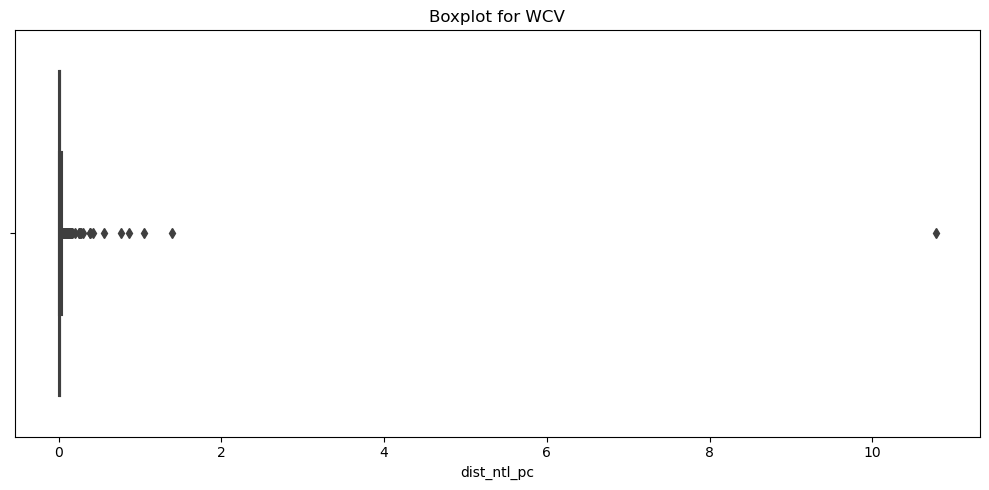

The upper whisker value is: 0.0399
The upper whisker value is: -0.0126


In [11]:

plt.figure(figsize=(10, 5))
sns.boxplot(data=ale, x='dist_ntl_pc', orient='h')
plt.title('Boxplot for Gini')

# Calculate whisker values
q1 = ale['dist_ntl_pc'].quantile(0.25)
q3 = ale['dist_ntl_pc'].quantile(0.75)
iqr = q3 - q1
upper_whisker_ntl = q3 + 1.5 * iqr
lower_whisker_ntl = q1 - 1.5 * iqr

# Add whisker values to the plot
# plt.text(1, upper_whisker, f'Upper Whisker: {upper_whisker_ntl:.4f}', ha='left', va='bottom', color='red')
# plt.text(1, lower_whisker, f'Lower Whisker: {lower_whisker_ntl:.4f}', ha='right', va='top', color='red')

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

print(f"The upper whisker value is: {upper_whisker_ntl:.4f}")
print(f"The upper whisker value is: {lower_whisker_ntl:.4f}")

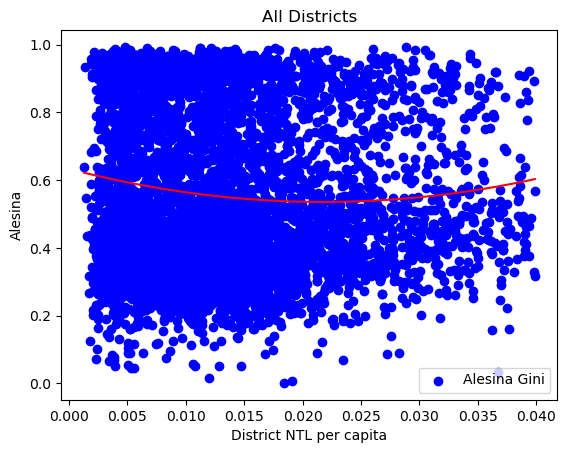

In [13]:
ale = ale[ale['dist_ntl_pc'] <= 0.04]
ale = ale[ale['alesina'] > 0]

# Create a scatterplot
plt.scatter(ale['dist_ntl_pc'], ale['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Alesina")
plt.title("All Sub-Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(ale['dist_ntl_pc'], ale['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(ale['dist_ntl_pc']), max(ale['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')

# Add a legend
plt.legend()
# Display the plot
plt.show()

### 2018

In [15]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from numpy.polynomial import Polynomial

# Set the float format to prevent scientific notation
pd.options.display.float_format = '{:.5f}'.format
pd.set_option('display.max_columns', None)

ma18 = pd.read_csv('/Users/sid/Library/CloudStorage/OneDrive-DeakinUniversity/UDocs - D/DataSets/VIIRS_Monthly_Tiled/2018/IN_villages_18_0.csv')

ma18 = ma18[ma18['avg_ntl'] != '#DIV/0!']
ma18['avg_ntl'] = ma18['avg_ntl'].astype(float)
# ma['total_population'] = pd.to_numeric(ma['total_population'], errors='coerce')
# ma = ma.dropna(subset=['total_population'])
# ma['total_population'] = ma['total_population'].astype(float)
values_to_drop = ['west pgs', 'New District', 'New Districtffff', 'Sadaruru']
# Dropping rows with specified values in the 'District' column
ma18 = ma18[~ma18['District'].isin(values_to_drop)]
# Merge DataFrames based on common columns
merged = pd.merge(ma18, ma[['village_code', 'Village', 'District', 'State', 'total_population']], 
                  on=['village_code', 'Village', 'District', 'State'], how='left')


In [17]:
me18 = merged.copy()
me18["ntl_pc"]= me18['avg_ntl']/me18['total_population']
mer_dist = me18.groupby(['District','District.c','State']).agg({'avg_ntl': 'sum', 'total_population': 'sum'}).reset_index()
mer_dist['avg_ntl'] = mer_dist['avg_ntl'].astype(float)
mer_dist = mer_dist.rename(columns={'avg_ntl': 'dist_ntl', 'total_population': 'dist_population'})
mer_dist['dist_ntl_pc'] = mer_dist['dist_ntl']/mer_dist['dist_population']
mer_all_dist = pd.merge(me18, mer_dist, on=['District','District.c','State'], how='outer')
mer_all_dist['pop_share'] = mer_all_dist['total_population']/mer_all_dist['dist_population']
mer_sorted = mer_all_dist.sort_values(by=['District', 'ntl_pc'])
mer_sorted['Index'] = mer_sorted.groupby('District').cumcount() + 1
# Creating a new column 'Max_Len' containing the maximum value of 'Index' within each district
mer_sorted['Max_Len'] = mer_sorted.groupby('District')['Index'].transform('max')
mer_sorted

,DTNAME,State.code,State,State.cens,District.c,District,District_1,SubDistrict,Subdistr_1,Subdistr_2,village_code,Village,Block.code,Block.Name,1/1/2018,1/2/2018,1/3/2018,1/4/2018,1/5/2018,1/6/2018,1/7/2018,1/8/2018,1/9/2018,1/10/2018,1/11/2018,1/12/2018,avg_ntl,total_population,ntl_pc,dist_ntl,dist_population,dist_ntl_pc,pop_share,Index,Max_Len
412268,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2331.00000,Haroa,2331.00000,323679.00000,Kuchhia Mora,2737.00000,HAROA,5.81954,8.14835,7.60416,8.12568,5.97985,8.11736,4.96544,5.71998,5.36201,7.09181,6.93230,5.57991,6.62053,18890.00000,0.00035,35880.58268,6382054.00000,0.00562,0.00296,1.00000,1677.00000
411934,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2327.00000,Deganga,2327.00000,323335.00000,Deganga,2733.00000,DEGANGA,10.46258,11.46497,8.42113,7.85935,7.24577,8.89062,7.00748,7.86538,6.84838,13.13475,12.32840,9.23064,9.22995,20757.00000,0.00044,35880.58268,6382054.00000,0.00562,0.00325,2.00000,1677.00000
411365,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2319.00000,Swarupnagar,2319.00000,322832.00000,Bayar Ghata,2744.00000,SWARUPNAGAR,1.28449,1.49339,1.20994,1.18041,0.92000,0.98551,0.68610,0.51036,0.80949,1.54730,1.67618,1.49503,1.14985,2395.00000,0.00048,35880.58268,6382054.00000,0.00562,0.00038,3.00000,1677.00000
412011,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2328.00000,Baduria,2328.00000,323479.00000,Tildanga,2724.00000,BADURIA,2.46170,3.01802,2.48172,3.15640,2.53988,2.86275,1.82269,1.45084,1.68563,2.71892,2.77629,2.42189,2.44973,4738.00000,0.00052,35880.58268,6382054.00000,0.00562,0.00074,4.00000,1677.00000
412331,NORTH TWENTY FOUR PARGAN*,19.00000,WESTBENGAL,19.00000,303.00000,24 PARAGANAS NORTH,337.00000,2331.00000,Haroa,2331.00000,323710.00000,Mallickpur,2737.00000,HAROA,2.41514,2.95552,2.50185,2.39478,2.28923,2.57017,1.94298,1.89144,2.03765,2.77798,2.74927,2.77859,2.44205,4700.00000,0.00052,35880.58268,6382054.00000,0.00562,0.00074,5.00000,1677.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70334,THIRUVANANTHAPURAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,204.92651,240.89120,227.19116,233.50491,0.00000,146.27443,213.66595,0.00000,256.03064,92.09740,188.40353,229.35876,203.23445,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70335,THIRUVANANTHAPURAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,145.29970,158.12201,160.20766,139.86101,0.00000,110.54823,153.43080,18.62797,169.15370,0.00000,132.09662,156.48694,134.38346,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70336,THIRUVANANTHAPURAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,488.08209,604.98065,552.98230,558.64502,0.00000,488.18912,512.25934,111.24058,682.23816,709.97357,452.36688,580.27448,521.93020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
70337,THIRUVANANTHAPURAM,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,172.47333,211.56862,205.57051,214.47551,70.95625,136.55629,208.32652,152.76768,208.80342,177.00011,151.71745,163.40977,172.80212,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
def calculate_alesina(group):
    sum_y = group['ntl_pc'].sum()
    num = group['Max_Len'].max()
    # numerator = ((group['Max_Len'] + 1 - group['Index']) * (group['ntl_pc'])).sum()
    numerator = ((num + 1 - group['Index']) * (group['ntl_pc'])).sum()
    pred = 1/num
    alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])
    return pd.Series([sum_y, numerator, num, alesina])

# ale = mer_sorted.groupby(['District']).apply(calculate_alesina).reset_index()

ale = mer_sorted.groupby(['District','District.c','State','dist_ntl','dist_population','dist_ntl_pc']).apply(calculate_alesina).reset_index()
# Rename the columns for clarity
ale.columns = ['District','District_code','State','dist_ntl',
               'dist_population','dist_ntl_pc','sum_y','numerator', 'num','alesina']
ale

/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_72876/394304723.py:7: RuntimeWarning: invalid value encountered in scalar divide
  alesina = pred * (num + 1 - ((2*numerator)/sum_y))##(1/group['Max_Len'])


,District,District_code,State,dist_ntl,dist_population,dist_ntl_pc,sum_y,numerator,num,alesina
0,24 PARAGANAS NORTH,303.00000,WESTBENGAL,35880.58268,6382054.00000,0.00562,72.10548,5205.92476,1677.00000,0.91449
1,24 PARAGANAS SOUTH,304.00000,WESTBENGAL,44243.28017,9661581.00000,0.00458,87.97868,9188.62047,2215.00000,0.90615
2,ADILABAD,501.00000,TELANGANA,15730.72636,596452.00000,0.02637,94.29198,4070.20761,554.00000,0.84597
3,AGAR MALWA,667.00000,MADHYA PRADESH,7315.69651,510258.00000,0.01434,7.49142,1174.47393,445.00000,0.29764
4,AGRA a,118.00000,UTTAR PRADESH,30861.35111,2970555.00000,0.01039,79.05232,2537.64964,789.00000,0.91990
...,...,...,...,...,...,...,...,...,...,...
593,YAVATMAL,500.00000,MAHARASHTRA,39001.97682,2281046.00000,0.01710,1541.59990,95874.63519,2019.00000,0.93889
594,demoz,724.00000,ANDHRA PRADESH,478.93012,68691.00000,0.00697,1.74690,71.84672,159.00000,0.48895
595,rewa a,726.00000,UTTAR PRADESH,28375.48712,3200711.00000,0.00887,16.04146,5980.32192,1337.00000,0.44308
596,test dist,730.00000,ANDHRA PRADESH,66723.23676,2300408.00000,0.02900,148.89653,18992.48586,1285.00000,0.80225


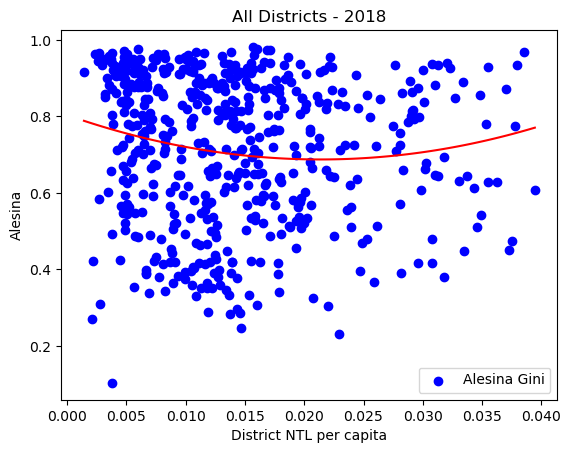

In [20]:

ale = ale[ale['dist_ntl_pc'] <= 0.04]
ale = ale[ale['alesina'] > 0]

# Create a scatterplot
plt.scatter(ale['dist_ntl_pc'], ale['alesina'], label='Alesina Gini', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Alesina")
plt.title("All Districts - 2018")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(ale['dist_ntl_pc'], ale['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(ale['dist_ntl_pc']), max(ale['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')

# Add a legend
plt.legend()
# Display the plot
plt.show()

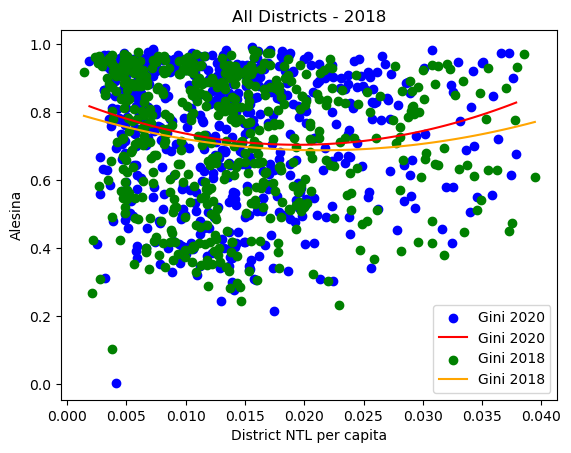

In [27]:
gini = gini[gini['dist_ntl_pc'] <= 0.04]
# gini = gini[gini['alesina'] > 0]
# gini = gini[gini['alesina'] < 1]

# Create a scatterplot
plt.scatter(gini['dist_ntl_pc'], gini['alesina'], label='Gini 2020', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Alesina")
plt.title("All Districts 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(gini['dist_ntl_pc'], gini['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(gini['dist_ntl_pc']), max(gini['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red',label="Gini 2020")

# Create a scatterplot
plt.scatter(ale['dist_ntl_pc'], ale['alesina'], label='Gini 2018', color='green', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Alesina")
plt.title("All Districts - 2018")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(ale['dist_ntl_pc'], ale['alesina'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(ale['dist_ntl_pc']), max(ale['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='orange',label="Gini 2018")



# plt.ylim(0, 1)

# Add a legend
plt.legend()
# Display the plot
plt.show()

## Theil Index

In [71]:
def calculate_theil(group):
    yi = group['ntl_pc']/group['dist_ntl_pc']
    the = (group['pop_share']*yi*np.log(yi)).sum()
    return pd.Series(the)

thei = meg_sorted.groupby(['District','District_code','State','dist_ntl','dist_population','dist_ntl_pc']).apply(calculate_theil).reset_index()

thei.columns = ['District','District_code','State','dist_ntl',
               'dist_population','dist_ntl_pc','theil']

In [72]:
thei

,District,District_code,State,dist_ntl,dist_population,dist_ntl_pc,theil
0,24 PARAGANAS NORTH,337.00000,WESTBENGAL,27768.72298,5979790.00000,0.00464,0.62236
1,24 PARAGANAS SOUTH,343.00000,WESTBENGAL,35600.34826,8740691.00000,0.00407,0.43266
2,ADILABAD,532.00000,TELANGANA,14509.40529,557344.00000,0.02603,0.43309
3,AGAR MALWA,0.00000,MADHYA PRADESH,7963.81906,504286.00000,0.01579,0.14250
4,AGRA a,146.00000,UTTAR PRADESH,24309.54446,2669545.00000,0.00911,0.27980
...,...,...,...,...,...,...,...
587,YAVATMAL,510.00000,MAHARASHTRA,39435.12096,2166418.00000,0.01820,0.54828
588,demoz,0.00000,ANDHRA PRADESH,478.78793,60945.00000,0.00786,0.41294
589,rewa a,0.00000,UTTAR PRADESH,24145.74876,3116857.00000,0.00775,0.19412
590,test dist,0.00000,ANDHRA PRADESH,59767.31391,2217985.00000,0.02695,0.46708


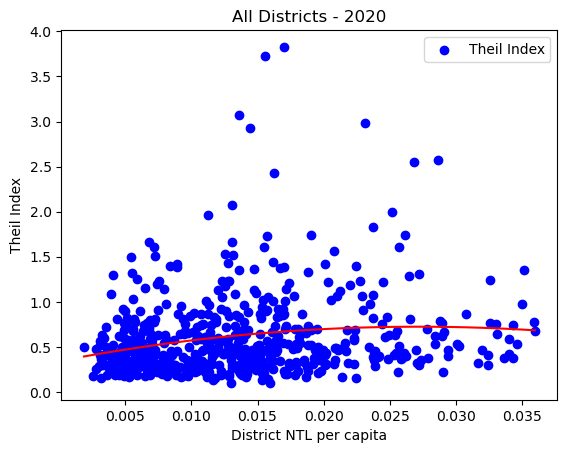

In [49]:
thei = thei[thei['dist_ntl_pc'] <= 0.0362]
# Create a scatterplot
plt.scatter(thei['dist_ntl_pc'], thei['theil'], label='Theil Index', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Theil Index")
plt.title("All Districts - 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(thei['dist_ntl_pc'], thei['theil'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(thei['dist_ntl_pc']), max(thei['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')

# plt.ylim(0, 1)

# Add a legend
plt.legend()
# Display the plot
plt.show()

### Theil - 2018

In [47]:
def calculate_theil(group):
    yi = group['ntl_pc']/group['dist_ntl_pc']
    the = (group['pop_share']*yi*np.log(yi)).sum()
    return pd.Series(the)

thei2 = mer_sorted.groupby(['District','District.c','State','dist_ntl','dist_population','dist_ntl_pc']).apply(calculate_theil).reset_index()
# Rename the columns for clarity
thei2.columns = ['District','District_code','State','dist_ntl',
               'dist_population','dist_ntl_pc','theil']
thei2


,District,District_code,State,dist_ntl,dist_population,dist_ntl_pc,theil
0,24 PARAGANAS NORTH,303.00000,WESTBENGAL,35880.58268,6382054.00000,0.00562,0.54704
1,24 PARAGANAS SOUTH,304.00000,WESTBENGAL,44243.28017,9661581.00000,0.00458,0.48369
2,ADILABAD,501.00000,TELANGANA,15730.72636,596452.00000,0.02637,0.36040
3,AGAR MALWA,667.00000,MADHYA PRADESH,7315.69651,510258.00000,0.01434,0.12806
4,AGRA a,118.00000,UTTAR PRADESH,30861.35111,2970555.00000,0.01039,0.26519
...,...,...,...,...,...,...,...
593,YAVATMAL,500.00000,MAHARASHTRA,39001.97682,2281046.00000,0.01710,0.52426
594,demoz,724.00000,ANDHRA PRADESH,478.93012,68691.00000,0.00697,0.41279
595,rewa a,726.00000,UTTAR PRADESH,28375.48712,3200711.00000,0.00887,0.12803
596,test dist,730.00000,ANDHRA PRADESH,66723.23676,2300408.00000,0.02900,0.47535


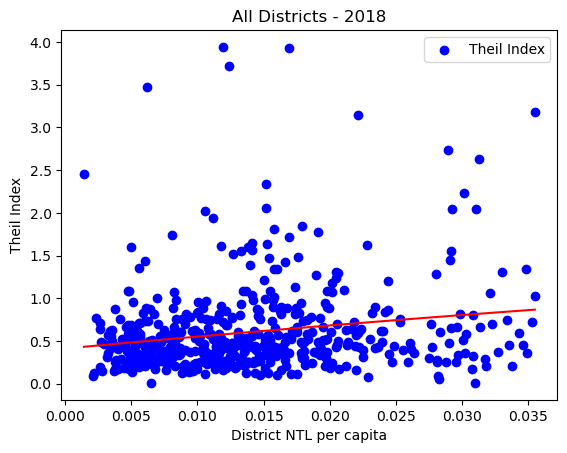

In [52]:
thei2 = thei2[thei2['dist_ntl_pc'] <= 0.0362]
# Create a scatterplot
plt.scatter(thei2['dist_ntl_pc'], thei2['theil'], label='Theil Index', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Theil Index")
plt.title("All Districts - 2018")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(thei2['dist_ntl_pc'], thei2['theil'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(thei2['dist_ntl_pc']), max(thei2['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')

# plt.ylim(0, 1)

# Add a legend
plt.legend()
# Display the plot
plt.show()

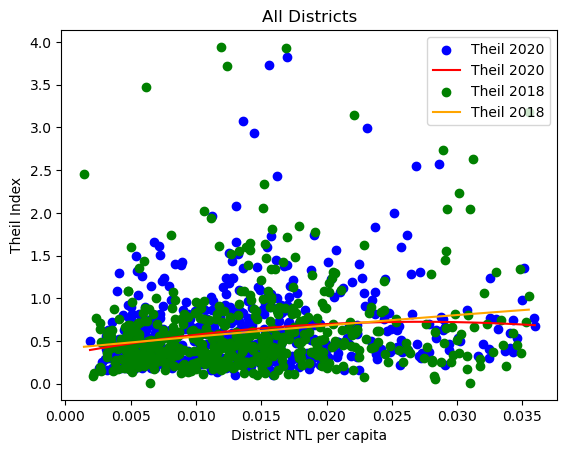

In [55]:
thei = thei[thei['dist_ntl_pc'] <= 0.0362]
# Create a scatterplot
plt.scatter(thei['dist_ntl_pc'], thei['theil'], label='Theil 2020', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Theil Index")
plt.title("All Districts")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(thei['dist_ntl_pc'], thei['theil'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(thei['dist_ntl_pc']), max(thei['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red',label="Theil 2020")


thei2 = thei2[thei2['dist_ntl_pc'] <= 0.0362]
# Create a scatterplot
plt.scatter(thei2['dist_ntl_pc'], thei2['theil'], label='Theil 2018', color='green', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("Theil Index")
plt.title("All Districts")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(thei2['dist_ntl_pc'], thei2['theil'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(thei2['dist_ntl_pc']), max(thei2['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='orange',label="Theil 2018")

# plt.ylim(0, 1)

# Add a legend
plt.legend()
# Display the plot
plt.show()

## Gini - OECD

In [78]:
def calculate_gini(group):
    num = group['Max_Len'].max()
    numerator = (((2*group['Index'])-num-1)*group['ntl_pc']).sum()
    den = num*(group['ntl_pc'].sum())
    alesina =  numerator/den
    return pd.Series([den, numerator, num, alesina])


all = meg_sorted.groupby(['District','District_code','State','dist_ntl','dist_population','dist_ntl_pc']).apply(calculate_gini).reset_index()
# Rename the columns for clarity
all.columns = ['District','District_code','State','dist_ntl',
               'dist_population','dist_ntl_pc','sum_y','numerator', 'num','gini']

ale = mer_sorted.groupby(['District','District.c','State','dist_ntl','dist_population','dist_ntl_pc']).apply(calculate_gini).reset_index()
# Rename the columns for clarity
ale.columns = ['District','District_code','State','dist_ntl',
               'dist_population','dist_ntl_pc','sum_y','numerator', 'num','gini']


/var/folders/gk/2dbxfg1d3g96xh9f5t1plpg00000gn/T/ipykernel_72876/1789457858.py:5: RuntimeWarning: invalid value encountered in scalar divide
  alesina =  numerator/den


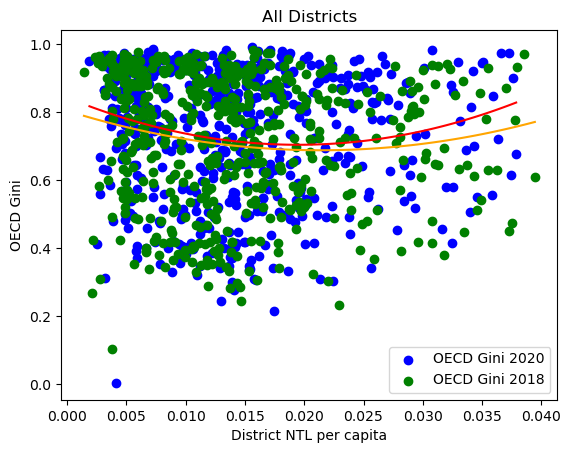

In [79]:
all = all[all['dist_ntl_pc'] <= 0.04]
all = all[all['gini'] > 0]
# gini = gini[gini['alesina'] < 1]

# Create a scatterplot
plt.scatter(all['dist_ntl_pc'], all['gini'], label='OECD Gini 2020', color='blue', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("OECD Gini")
plt.title("All Districts - 2020")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(all['dist_ntl_pc'], all['gini'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(all['dist_ntl_pc']), max(all['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='red')

ale = ale[ale['dist_ntl_pc'] <= 0.04]
ale = ale[ale['gini'] > 0]

# Create a scatterplot
plt.scatter(ale['dist_ntl_pc'], ale['gini'], label='OECD Gini 2018', color='green', marker='o')
# Add labels and title
plt.xlabel("District NTL per capita")
plt.ylabel("OECD Gini")
plt.title("All Districts")
# Fit a polynomial best fit line (e.g., a quadratic curve)
coefficients = np.polyfit(ale['dist_ntl_pc'], ale['gini'], 2)  # Adjust the degree as needed
polynomial = np.poly1d(coefficients)
x_range = np.linspace(min(ale['dist_ntl_pc']), max(ale['dist_ntl_pc']), 100)
y_fit = polynomial(x_range)
# Plot the polynomial best fit line
plt.plot(x_range, y_fit, color='orange')


# plt.ylim(0, 1)

# Add a legend
plt.legend()
# Display the plot
plt.show()